## Brainstorming
* By predicting the market cap directly from the macroeconomic indicators using different lag times, we can observe the change in feature importance by time lag. Things to look at:
    * Is the feature importance of macroeconomic indicators consistent among companies/sectors?
    * Although linear regression is not affected by scaling, how can we interpret the coefficients and compare their importance when they are unscaled? Keeping them unscaled will give us information like increasing indicator X by a increases the market cap by b. However, scaling the indicators will help us rank the features by importance.

# To do

* ~Check the correlation between the indicators we are using~
* Repeat analysis using different time lags
* Repeat analysis by combining companies in sectors
* Try direct feature importance methods instead of linear regression
* Create functions to directly generate datasets with certain time lags
* Study the effect of including temporal changes in the indicators

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
from pathlib import Path
import re
import json
import seaborn as sns

from ProjectPackage.util import get_ticker, HIGHLY_CORRELATED_FEATURES

In [7]:
# Loading target data
df = pd.read_csv('processed_data/feature_data.csv', parse_dates=['date'])
market_cap = pd.read_csv('processed_data/target_data.csv', parse_dates=['date'])

# Converting market cap to million dollar for easier interpretation of coefficients
market_cap['marketcap'] /= 1e6

# Leaving 2017 and 2018 out as test data
cond = df['date'].dt.year < 2017
df = df.loc[cond].reset_index(drop=True)

cond = market_cap['date'].dt.year < 2017
market_cap = market_cap.loc[cond].reset_index(drop=True)

# Dropping highly correlated features
df = df.drop(columns=HIGHLY_CORRELATED_FEATURES)

In [8]:
display(df.head(2))
display(market_cap.head(2))

,date,year,month,consumer_credits,consumer_price_index,brent_oil_price,current_account_deficit,exports_usd,imports_usd,export_unit_value_index_usd,...,gold_price_lon,B,C,MIG_NRG_X_E,MIG_DCOG,interest_rates_personal,money_supply,real_effective_echange_rates,retail_sales,unemployment_30-34
0,2009-01-01,2009,1,5.074031e+10,160.90,43.44,-330000000,7884493524,9281137649,95.1,...,870.15,72.9,48.9,82.4,49.2,22.8580,5.106825e+07,95.56,3.945135e+07,13.8
1,2009-02-01,2009,2,4.863385e+10,160.35,43.32,-150000000,8435115834,9074663754,90.9,...,947.38,60.5,48.0,73.1,52.6,21.4725,5.232834e+07,93.34,1.199247e+07,14.9


,date,year,month,ticker,firm,sector,marketcap
0,2009-01-01,2009,1,ALYAG,ALTINYAĞ,NaN,6.783538
1,2009-01-01,2009,1,AEFES,ANADOLU EFES,MANUFACTURING,3143.382849


Trying one model for each company

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold

In [10]:
def MAPE(y_true, y_pred):
    '''
    MAPE is the mean absolute percentage error.
    '''
    
    return np.abs((y_true - y_pred) / y_true).sum() / y_true.shape[0]

In [11]:
X = df.iloc[:, 3:].copy()

### Modeling without time features
In this section we create models without looking at time features, i.e., we try to predict the market cap of a month by looking at that month's macroeconomic indicators only, which is a very naive approach as it does not include lag effects.

In [12]:
# Defining random state for shuffling data
random_state = 763

X = X.sample(n=X.shape[0], random_state=random_state)
shuffle_idx = X.index

In [13]:
# Defining metrics
score_fun_dict={
    'MAE': mean_absolute_error,
    'MAPE': MAPE,
    'RMSE': lambda x, y: np.sqrt(mean_squared_error(x, y)),
    'rRMSE': lambda x, y: np.sqrt(mean_squared_error(x, y)) / np.mean(x),
    'R2': r2_score,
}

def get_score_dict(y_true, y_pred, model_score_dict, score_fun_dict=score_fun_dict):
    
    if not model_score_dict:
        model_score_dict = {metric: [] for metric in score_fun_dict.keys()}
        
    for metric, fun in score_fun_dict.items():
        model_score_dict[metric].append(fun(y_true, y_pred))
        
    return model_score_dict


def save_scores(general_score_dict, model_score_dict, name):
    general_score_dict['ticker'].append(name)
    for metric, score in model_score_dict.items():
        general_score_dict[metric+'_mean'].append(np.mean(score))
        general_score_dict[metric+'_std'].append(np.std(score))
        
    return general_score_dict


def save_predictions():
    pass


def conduct_cv(model, X, y, n_folds=5, score_fun_dict=score_fun_dict):
    cv = KFold(n_folds)
    model_score_dict = {}
    
    predictions = np.zeros(y.shape)
    
    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
        X_train = X.loc[train_index]
        y_train = y.loc[train_index]
        X_test = X.loc[test_index]
        y_test = y.loc[test_index]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        predictions[test_index] = y_pred
        
        model_score_dict = get_score_dict(y_test, y_pred, model_score_dict)
        
    return model_score_dict, predictions

In [16]:
general_score_dict = {'ticker': []}
general_score_dict.update({f'{x}_{y}': [] for x in score_fun_dict.keys() for y in ['mean', 'std']})

general_pred_dict = {}

tickers = market_cap['ticker'].unique()

model_dict = {}

for ticker in tickers:
    data = get_ticker(market_cap, ticker)
    y = data['marketcap']
    
    # Shuffling data
    y = y.loc[shuffle_idx]
    
    # Conducting cross validation
    model = LinearRegression()

    model_score_dict, predictions = conduct_cv(model, X, y)
    
    general_score_dict = save_scores(general_score_dict, model_score_dict, ticker)
    general_pred_dict[ticker] = predictions
    
    # Training model on data up to 
    model = LinearRegression()
    model.fit(X, y)
    model_dict[ticker] = model

In [17]:
results_df = pd.DataFrame(general_score_dict)

In [18]:
results_df.describe()

,MAE_mean,MAE_std,MAPE_mean,MAPE_std,RMSE_mean,RMSE_std,rRMSE_mean,rRMSE_std,R2_mean,R2_std
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,174.582120,72.078680,0.461310,0.380635,205.619799,79.300775,0.452528,0.298001,-13.589783,22.225010
std,362.381989,155.986945,0.405599,0.516246,426.639821,170.041312,0.341975,0.376379,35.893019,68.162074
min,0.983348,0.244071,0.084965,0.024374,1.194218,0.259048,0.104336,0.026521,-295.158523,0.291183
25%,11.955840,4.819229,0.223761,0.111545,14.308357,5.513707,0.244079,0.099690,-11.787557,1.872827
50%,34.810981,14.436758,0.333613,0.200431,40.074687,15.614902,0.348837,0.179096,-4.087438,4.772966
75%,116.932402,57.812334,0.549311,0.457883,141.503934,62.522334,0.576425,0.363011,-1.600440,14.130368
max,1696.635584,1053.208716,3.318222,4.373180,2040.614619,1112.850674,3.049832,3.716863,0.402505,562.756198


Observing the "best results"

In [19]:
idx = np.argmax(results_df['R2_mean'])
results_df.loc[idx]

ticker              TSKB
MAE_mean       84.100389
MAE_std        11.480208
MAPE_mean       0.103102
MAPE_std         0.04797
RMSE_mean     100.736888
RMSE_std        9.126284
rRMSE_mean      0.104336
rRMSE_std       0.027484
R2_mean         0.402505
R2_std          0.406192
Name: 143, dtype: object

In [21]:
idx = np.argmin(results_df['MAPE_mean'])
results_df.loc[idx]

ticker            BTCIM
MAE_mean      20.654047
MAE_std        4.833818
MAPE_mean      0.084965
MAPE_std       0.032359
RMSE_mean     26.526741
RMSE_std       6.718023
rRMSE_mean     0.106432
rRMSE_std      0.037871
R2_mean       -0.175121
R2_std         1.505052
Name: 58, dtype: object

### Plotting predictions

In [22]:
def plot_model_predictions(ticker, model, ax=None, metric='MAE'):

    data = get_ticker(market_cap, ticker)

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 4))

    # Plotting true values
    ax.plot('date', 'marketcap', data=data, color='gray', alpha=0.6, label='True value')

    # Plotting the 5-fold Test predictions
    y_hat = general_pred_dict[ticker]
    ax.plot(data['date'], y_hat, color='limegreen', alpha=0.6, label='5-fold Test predictions')

    # Plotting the train predictions
    y_hat = model.predict(X.sort_index())
    ax.plot(data['date'], y_hat, color='skyblue', alpha=0.6, label='Train predictions')
    
    # Model score
    cond = results_df['ticker'] == ticker
    score = results_df.loc[cond, metric+'_mean'].squeeze()
    
    ax.set_title(f'{ticker} / 5-fold {metric} mean = {score:.3f}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Market cap (Million USD)')

    ax.legend()

In [23]:
tickers = market_cap['ticker'].unique()

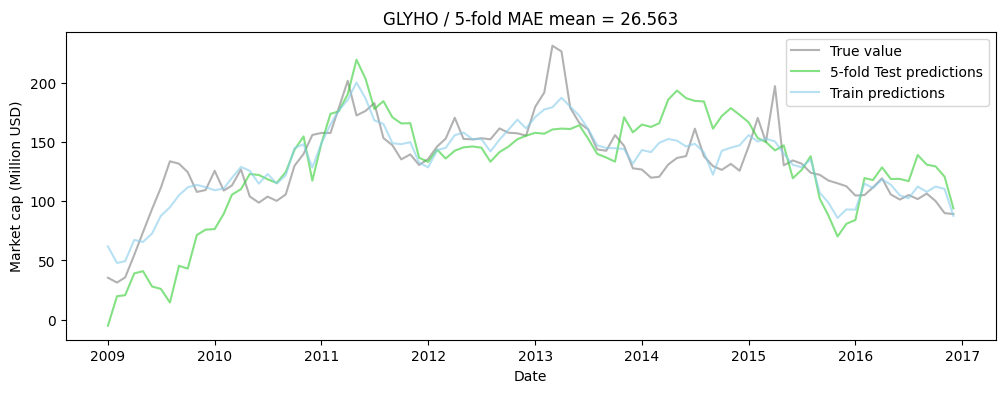

In [34]:
# Sample ticker
ticker = np.random.choice(tickers)

data = get_ticker(market_cap, ticker)
y = data['marketcap']

model = LinearRegression()
model.fit(X.sort_index(), y.sort_index())
plot_model_predictions(ticker, model, ax=None)

plt.show()

#### Notes:
* Here we are predicting the market cap of each company from the macroeconomic indicators **of the same month**. There is no future prediction made here.

### Coefficient Exploration

1. Without normalization

In [26]:
coef_dict = {'ticker': []}

coef_dict.update({col: [] for col in X.columns})

for ticker, model in model_dict.items():
    coef_dict['ticker'].append(ticker)
    for i, col in enumerate(X.columns):
        coef_dict[col].append(model.coef_[i])

In [27]:
coefficients = pd.DataFrame(coef_dict)
coefficients.describe()

,consumer_credits,consumer_price_index,brent_oil_price,current_account_deficit,exports_usd,imports_usd,export_unit_value_index_usd,gdp,gold_price_lon,B,C,MIG_NRG_X_E,MIG_DCOG,interest_rates_personal,money_supply,real_effective_echange_rates,retail_sales,unemployment_30-34
count,2.150000e+02,215.000000,215.000000,2.150000e+02,2.150000e+02,2.150000e+02,215.000000,2.150000e+02,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,2.150000e+02,215.000000,2.150000e+02,215.000000
mean,7.616791e-09,0.243033,-1.945996,1.468967e-08,-1.190110e-08,1.769339e-08,7.778879,2.312811e-10,0.213583,-2.289364,1.765407,1.410196,1.705933,-28.562213,-5.768036e-06,17.940779,-1.668945e-07,-3.986208
std,2.657660e-08,7.173083,8.142223,6.509419e-08,7.833612e-08,7.659298e-08,32.133220,4.157984e-09,0.999097,9.149968,10.397125,7.433868,6.396795,88.792764,2.341530e-05,57.461326,1.116191e-06,48.211998
min,-3.160343e-08,-54.370154,-52.005445,-1.584603e-07,-5.089272e-07,-1.877954e-07,-115.988230,-1.336747e-08,-3.789451,-56.733022,-29.913890,-33.453467,-21.057034,-632.314944,-1.631476e-04,-5.334483,-8.630079e-06,-393.401030
25%,-8.606613e-10,-0.096373,-1.262560,-1.055655e-09,-9.372105e-09,-8.341131e-10,0.141635,-3.645106e-10,-0.000131,-1.601251,-0.247190,0.005113,0.014878,-14.398869,-2.225098e-06,0.558518,-1.328872e-07,-3.882247
50%,-2.827352e-12,0.107175,-0.193291,5.979305e-10,-1.461128e-09,1.008399e-09,1.561984,-5.969760e-11,0.022030,-0.295162,0.195246,0.230487,0.245133,-2.685968,-3.564304e-07,2.033364,-3.158034e-08,-0.481325
75%,2.391897e-09,0.906149,0.056048,5.258198e-09,8.047827e-10,6.894454e-09,6.517050,5.468250e-11,0.099748,0.016190,1.247203,1.037000,0.869157,-0.389299,1.334240e-07,7.961743,9.622252e-09,1.650790
max,1.382663e-07,28.547314,42.063849,4.352822e-07,2.704921e-07,4.547860e-07,230.288080,2.695049e-08,6.814973,17.782231,92.873127,48.042864,59.612047,44.017965,4.616346e-05,446.060451,4.882067e-06,191.213768


2. With normalization

In [28]:
tickers = market_cap['ticker'].unique()

coef_dict = {'ticker': []}
coef_dict.update({col: [] for col in X.columns})

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

for ticker in tickers:
    coef_dict['ticker'].append(ticker)
    
    model = LinearRegression()
    y = get_ticker(market_cap, ticker)['marketcap']
    
    model.fit(X_norm, y)
    
    for i, col in enumerate(X.columns):
        coef_dict[col].append(model.coef_[i])
        
coefficients_norm = pd.DataFrame(coef_dict)

In [29]:
vals = coefficients_norm.drop(columns=['ticker'])

# Dropping outliers
q1 = vals.quantile(0.25)
q3 = vals.quantile(0.75)
iqr = q3 - q1

low_bound = q1 - 1.5*iqr
upp_bound = q3 + 1.5 * iqr

data_to_plot = []
for col in vals.columns:
    cond = (vals[col] >= low_bound[col]) & (vals[col] <= upp_bound[col])
    data_to_plot.append(vals.loc[cond, col].to_numpy())
    

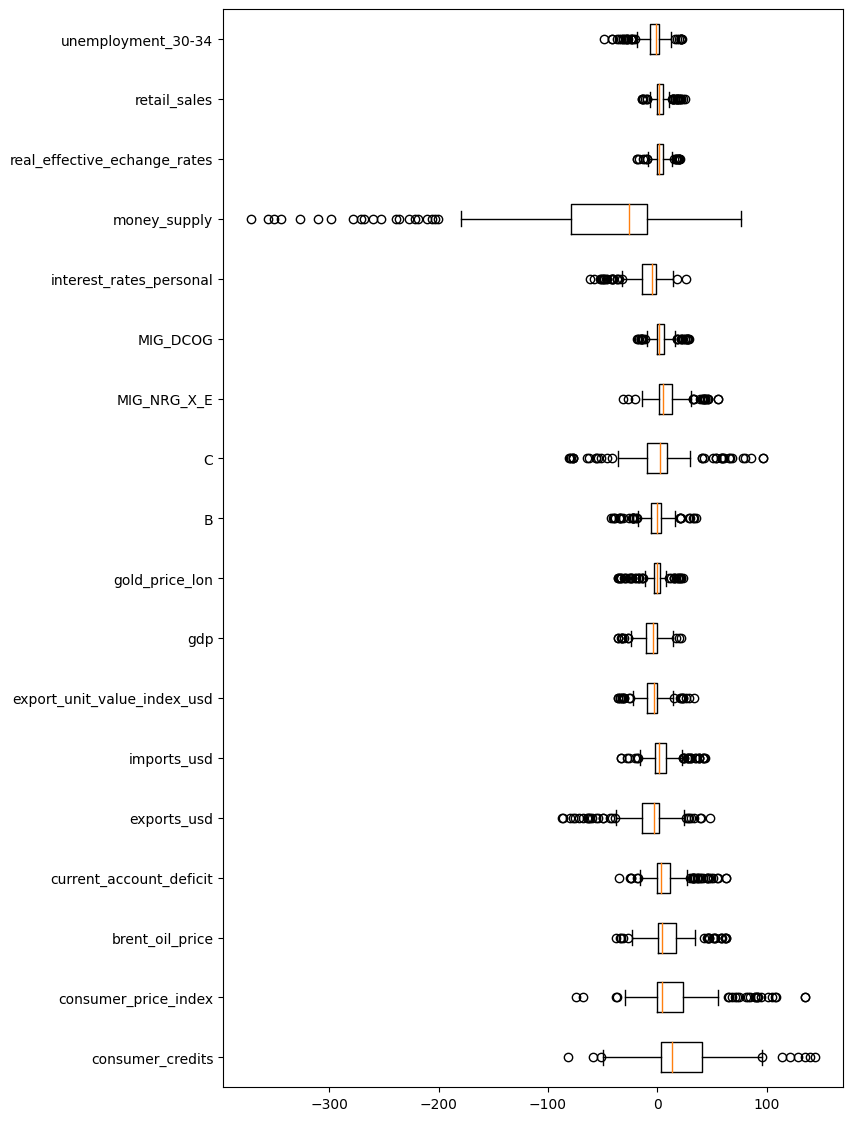

In [31]:
fig, ax = plt.subplots(figsize=(8, 14))

ax.boxplot(x=data_to_plot, vert=False, labels=vals.columns)
plt.show()

In [32]:
coefficients_norm.drop(columns=['ticker']).median()

consumer_credits                15.714031
consumer_price_index             8.553510
brent_oil_price                  6.426841
current_account_deficit          5.700999
exports_usd                     -4.377882
imports_usd                      2.538677
export_unit_value_index_usd     -1.650722
gdp                             -3.915873
gold_price_lon                  -0.214576
B                               -0.454635
C                                2.602120
MIG_NRG_X_E                      6.752532
MIG_DCOG                         2.262049
interest_rates_personal         -6.352077
money_supply                   -34.446999
real_effective_echange_rates     1.411134
retail_sales                     2.758477
unemployment_30-34              -2.658832
dtype: float64

### Market cap distribution

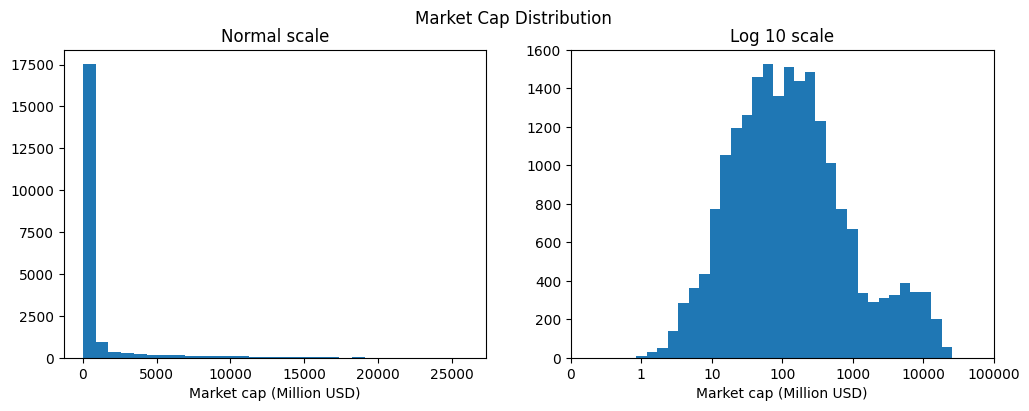

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

fig.suptitle('Market Cap Distribution')

ax = axs[0]
ax.set_title('Normal scale')
ax.hist(market_cap['marketcap'], bins=30)
ax.set_xlabel('Market cap (Million USD)')

ax = axs[1]
ax.set_title('Log 10 scale')
ax.hist(np.log10(market_cap['marketcap']), bins=30)
ax.set_xlabel('Market cap (Million USD)')
xticks = ax.get_xticks()
ax.set_xticks(xticks)
ax.set_xticklabels([f'{10**x:.0f}' for x in xticks])

plt.show()